# Blackjack Card Point Detection Project 🃏

This notebook guides you through building a card recognition system for blackjack.
You upload a photo of a blackjack game, and the system will:
- Detect each card
- Recognize its number (A–K)
- Group cards by player
- Count points based on blackjack rules
- Decide who won

🟩 Subtask 1: Import Required Libraries
Goal: Load all Python libraries you'll use.

Explanation:
You need libraries like:

cv2 (OpenCV) for image processing,

numpy for numerical operations,

matplotlib.pyplot to visualize steps,

glob and os to load template files.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from matplotlib.patches import Rectangle

# Display settings for better visualization
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['image.cmap'] = 'gray'

print("All libraries imported successfully!")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")

#code for subtask 1 here

All libraries imported successfully!
OpenCV version: 4.11.0
NumPy version: 2.2.6


🟩 Subtask 2: Load and Preprocess the Input Image
Goal: Read cards.png and make it easier to detect cards.

Explanation:

Convert to grayscale → easier processing.

Apply Gaussian blur → reduce noise.

Use Canny edge detection → highlight edges of the cards.

This prepares the image for finding contours.

Image loaded successfully! Shape: (1134, 1364, 3)


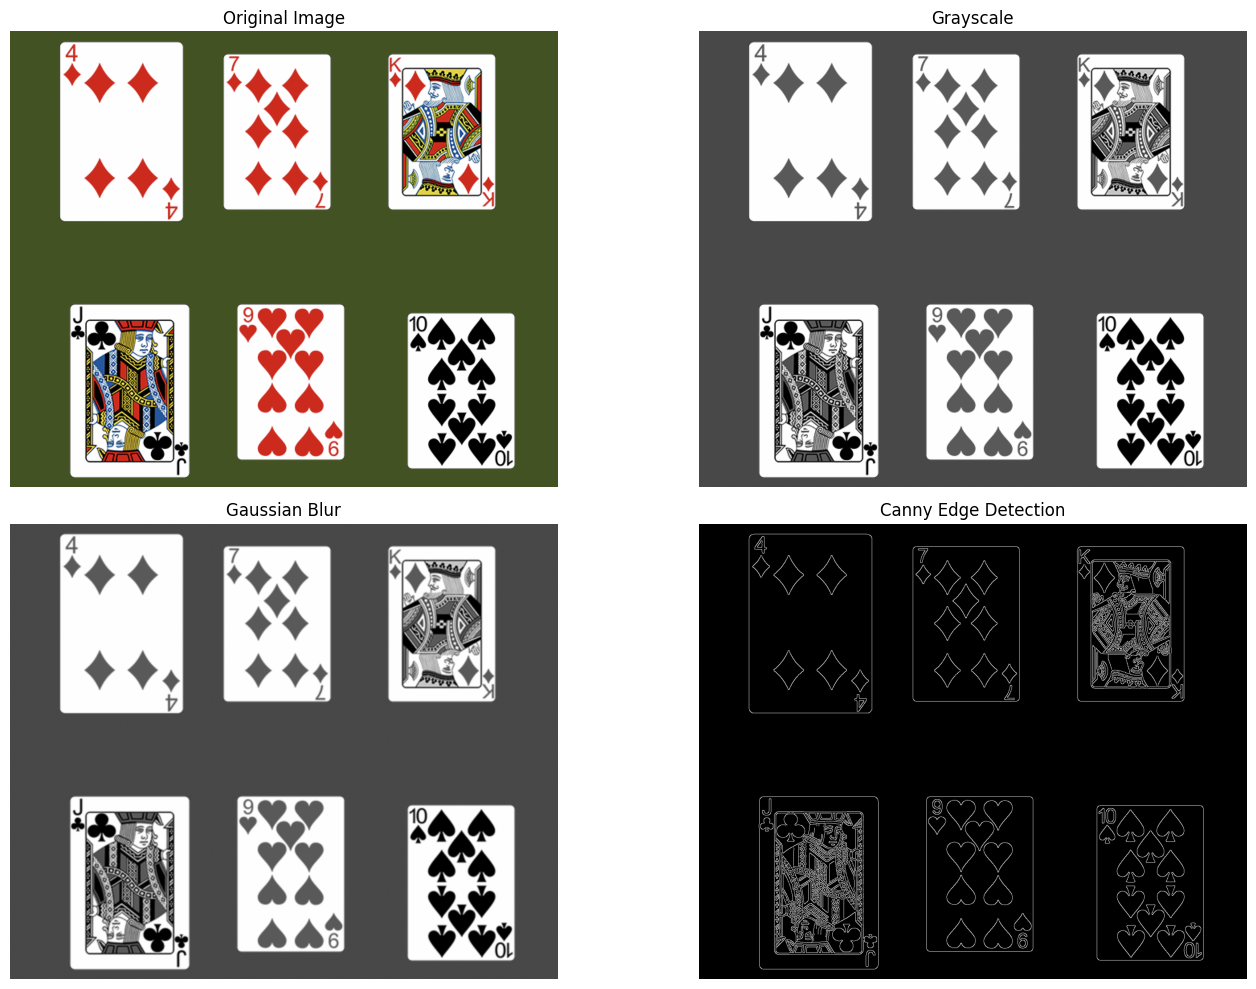

Preprocessing completed successfully!
Original image shape: (1134, 1364, 3)
Grayscale shape: (1134, 1364)
Edge detection ready for contour finding


In [21]:
# Load the input image
image_path = 'cards8.png'
original_image = cv2.imread(image_path)

if original_image is None:
    print(f"Error: Could not load image from {image_path}")
    print("Make sure the cards.png file is in the current directory")
else:
    print(f"Image loaded successfully! Shape: {original_image.shape}")
    
    # Convert BGR to RGB for matplotlib display
    original_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale for processing
    gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    # Display the preprocessing steps
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].imshow(original_rgb)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(gray, cmap='gray')
    axes[0, 1].set_title('Grayscale')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(blurred, cmap='gray')
    axes[1, 0].set_title('Gaussian Blur')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(edges, cmap='gray')
    axes[1, 1].set_title('Canny Edge Detection')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("Preprocessing completed successfully!")
    print(f"Original image shape: {original_image.shape}")
    print(f"Grayscale shape: {gray.shape}")
    print(f"Edge detection ready for contour finding")

🟩 Subtask 3: Detect Individual Cards Using Contours
Goal: Find and extract the rectangular outlines of each card.

Explanation:

Use cv2.findContours() to find all contours.

Filter for contours that:

Have 4 corners (i.e., rectangles),

Have a large enough area (to ignore noise).

This step gives you the bounding box for each card in the image.

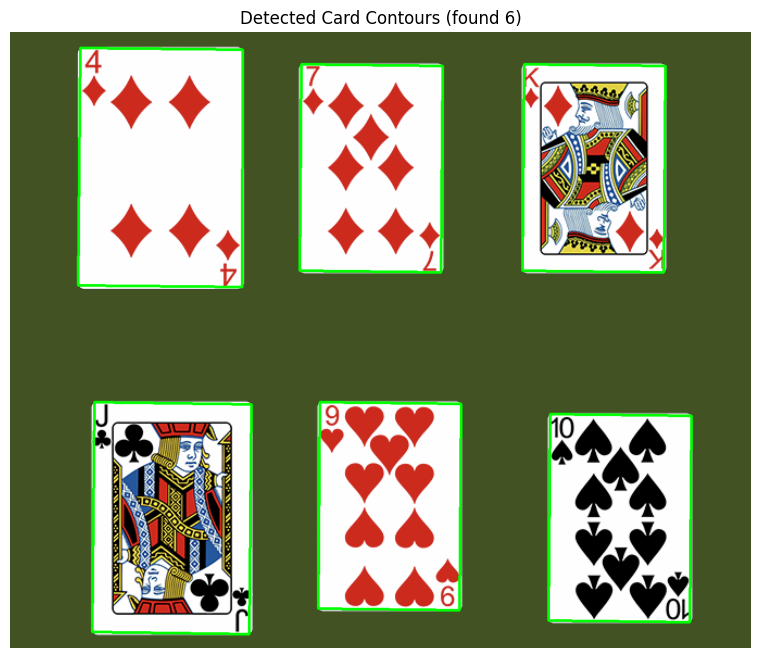

Number of card-like contours detected: 6


In [24]:
# Detect contours in the edge image
# Find contours in the edge image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours: only keep quadrilaterals of sufficient area (likely cards)
card_contours = []
min_area = 10000  # Minimum area to filter out small noise; adjust if necessary

for cnt in contours:
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
    if len(approx) == 4 and cv2.contourArea(cnt) > min_area:
        card_contours.append(approx)

# Draw detected card contours on a copy of the original image for verification
contour_img = original_rgb.copy()
for cnt in card_contours:
    cv2.drawContours(contour_img, [cnt], -1, (0, 255, 0), 4)

plt.figure(figsize=(10, 8))
plt.imshow(contour_img)
plt.title(f'Detected Card Contours (found {len(card_contours)})')
plt.axis('off')
plt.show()

print(f"Number of card-like contours detected: {len(card_contours)}")

Dealer contours found: 3
Player contours found: 3


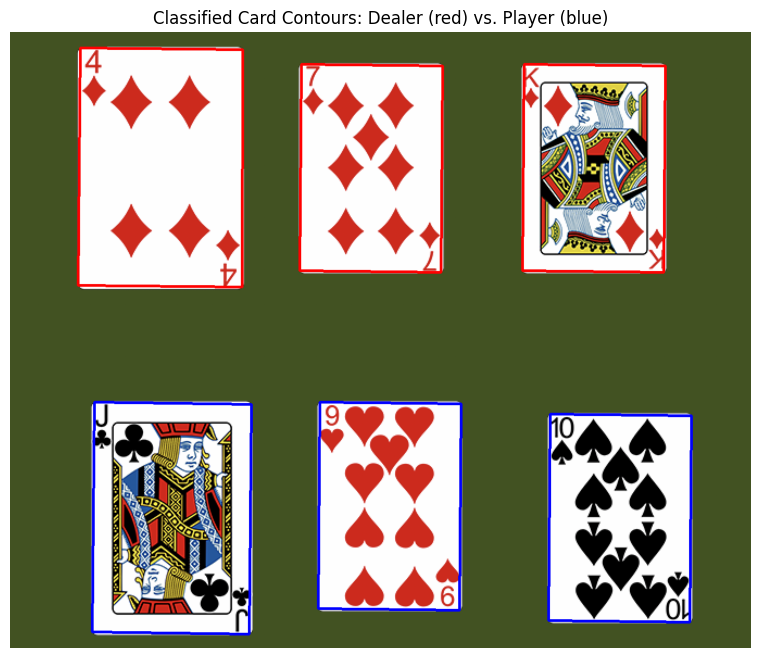

In [25]:
# New: Classify contours into dealer vs. player based on vertical position
# -----------------------------------------------------------------------------------

# Get image height to decide divider line (upper half = dealer, lower half = player)
img_height = original_image.shape[0]

dealer_contours = []  # will hold contours in the upper half
player_contours = []  # will hold contours in the lower half

for cnt in card_contours:
    # Compute the centroid (center) of the contour using moments
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cY = int(M["m01"] / M["m00"])  # y-coordinate of centroid
    else:
        # Fallback: use bounding rectangle center if M["m00"] == 0
        x, y, w_box, h_box = cv2.boundingRect(cnt)
        cY = y + h_box // 2
    
    # If centroid is in upper half, it's dealer's card; otherwise player's card
    if cY < img_height / 2:
        dealer_contours.append(cnt)
    else:
        player_contours.append(cnt)

print(f"Dealer contours found: {len(dealer_contours)}")
print(f"Player contours found: {len(player_contours)}")

# Optional: visualize classification (dealer in red, player in blue)
visual_class = original_rgb.copy()
for cnt in dealer_contours:
    cv2.drawContours(visual_class, [cnt], -1, (255, 0, 0), 3)  # red for dealer
for cnt in player_contours:
    cv2.drawContours(visual_class, [cnt], -1, (0, 0, 255), 3)  # blue for player

plt.figure(figsize=(10, 8))
plt.imshow(visual_class)
plt.title('Classified Card Contours: Dealer (red) vs. Player (blue)')
plt.axis('off')
plt.show()

🟩 Subtask 4: Sort Cards Left-to-Right (Optional but Recommended)
Goal: Ensure consistent card order.

Explanation:

Use the x-position of each card's bounding box to sort them.

Helps with debugging, and makes the output predictable.

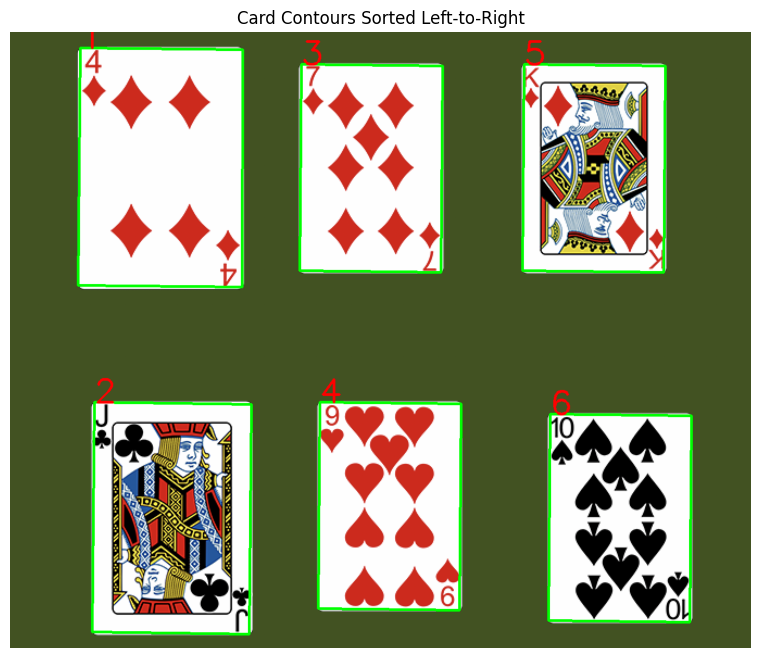

Card contours sorted left-to-right.


In [26]:
# Sort card contours left-to-right by the x-coordinate of their top-left corner
def get_leftmost_point(contour):
    # contour shape: (4, 1, 2)
    pts = contour.reshape(4, 2)
    return np.min(pts[:, 0])

card_contours = sorted(card_contours, key=get_leftmost_point)

# Visualize the sorted order by numbering the cards
sorted_img = original_rgb.copy()
for idx, cnt in enumerate(card_contours):
    cv2.drawContours(sorted_img, [cnt], -1, (0, 255, 0), 4)
    # Find the top-left point for placing the number
    pts = cnt.reshape(4, 2)
    top_left = pts[np.argmin(pts[:, 0] + pts[:, 1])]
    cv2.putText(sorted_img, str(idx+1), tuple(top_left), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 4)

plt.figure(figsize=(10, 8))
plt.imshow(sorted_img)
plt.title('Card Contours Sorted Left-to-Right')
plt.axis('off')
plt.show()

print('Card contours sorted left-to-right.')
# card_contours is now sorted for further processing

🟩 Subtask 5: Warp Each Card to a Standard Size
Goal: Get a clean top-down view of each card regardless of angle.

Explanation:

Use the 4-point perspective transform to "flatten" each card.

This ensures that the position and size of the rank symbol will be consistent, making the next steps more accurate.

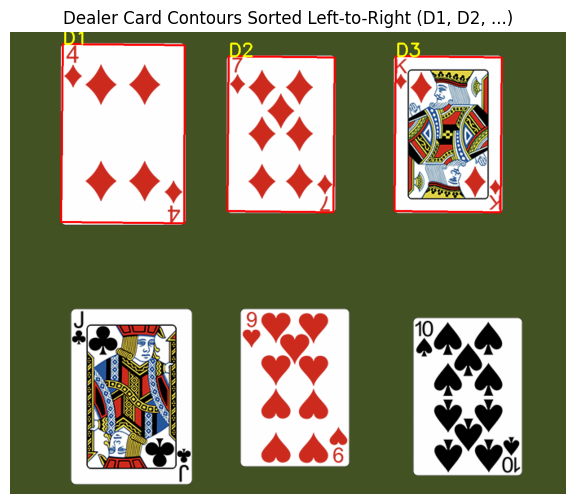

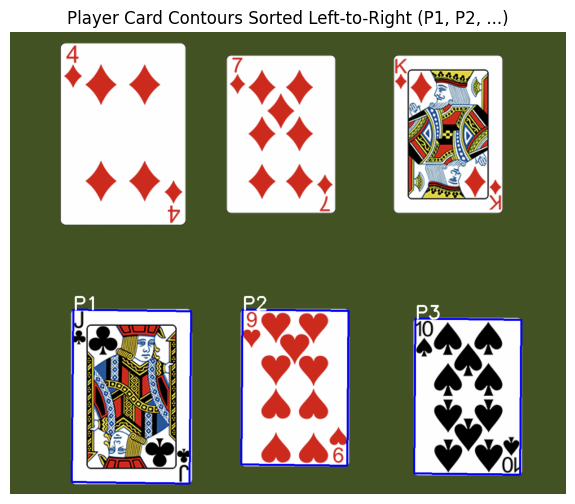

Contours for dealer and player sorted left-to-right.


In [31]:
# Subtask 5: Warp Each Card to a Standard Size

def order_points(pts):
    """
    Orders the four points of a quadrilateral contour into:
    top-left, top-right, bottom-right, bottom-left.
    This ordering is needed for a correct perspective transform.
    """
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]      # top-left has smallest sum
    rect[2] = pts[np.argmax(s)]      # bottom-right has largest sum
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]   # top-right has smallest difference
    rect[3] = pts[np.argmax(diff)]   # bottom-left has largest difference
    return rect

def four_point_transform(image, pts, width=200, height=300):
    """
    Performs a perspective transform on the region defined by pts in the image.
    The output is a top-down view of size (width x height).
    """
    rect = order_points(pts)
    dst = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (width, height))
    return warped

dealer_contours = sorted(dealer_contours, key=get_leftmost_point)
player_contours = sorted(player_contours, key=get_leftmost_point)

# Visualize sorted contours by numbering within each group
# Dealer group
sorted_dealer_img = original_rgb.copy()
for idx, cnt in enumerate(dealer_contours):
    cv2.drawContours(sorted_dealer_img, [cnt], -1, (255, 0, 0), 4)  # blue-ish for dealer
    pts = cnt.reshape(4, 2)
    top_left = pts[np.argmin(pts[:, 0] + pts[:, 1])]
    cv2.putText(sorted_dealer_img, f"D{idx+1}", tuple(top_left),
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 0), 3)

plt.figure(figsize=(10, 6))
plt.imshow(sorted_dealer_img)
plt.title('Dealer Card Contours Sorted Left-to-Right (D1, D2, ...)')
plt.axis('off')
plt.show()

# Player group
sorted_player_img = original_rgb.copy()
for idx, cnt in enumerate(player_contours):
    cv2.drawContours(sorted_player_img, [cnt], -1, (0, 0, 255), 4)  # red for player
    pts = cnt.reshape(4, 2)
    top_left = pts[np.argmin(pts[:, 0] + pts[:, 1])]
    cv2.putText(sorted_player_img, f"P{idx+1}", tuple(top_left),
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)

plt.figure(figsize=(10, 6))
plt.imshow(sorted_player_img)
plt.title('Player Card Contours Sorted Left-to-Right (P1, P2, ...)')
plt.axis('off')
plt.show()

print('Contours for dealer and player sorted left-to-right.')

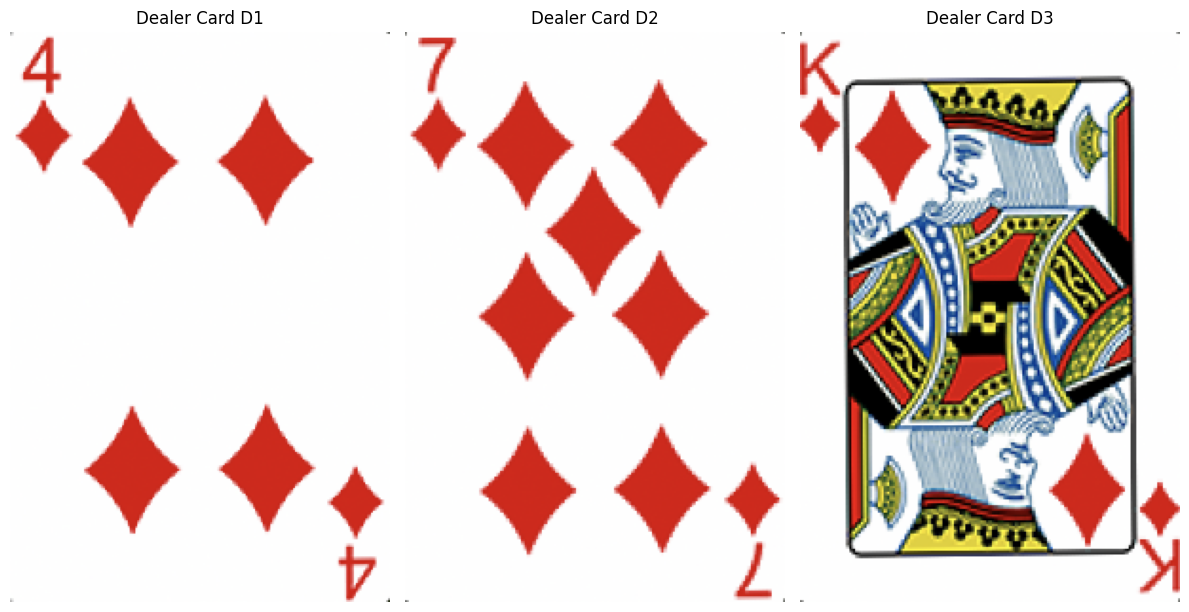

Warped 3 dealer cards to a standard size (200x300).


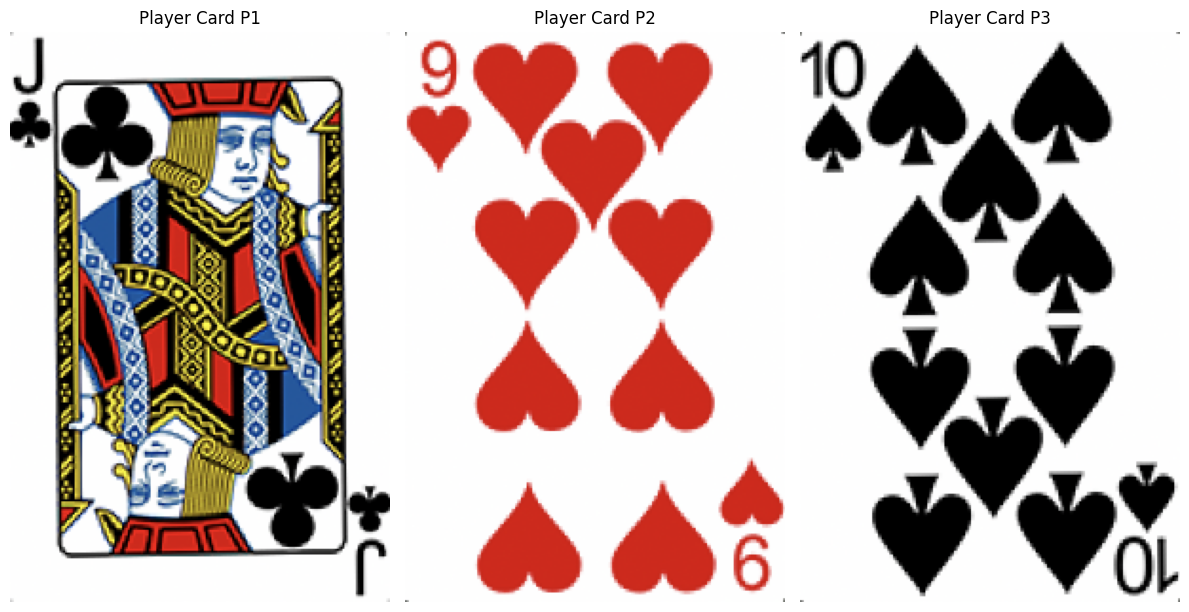

Warped 3 player cards to a standard size (200x300).


In [33]:
# Warp each card to a standard size (200x300) for dealer and player separately
# -----------------------------------------------------------------------------------

warped_dealer_cards = []
for idx, cnt in enumerate(dealer_contours):
    pts = cnt.reshape(4, 2)
    warped = four_point_transform(original_image, pts)
    warped_dealer_cards.append(warped)

warped_player_cards = []
for idx, cnt in enumerate(player_contours):
    pts = cnt.reshape(4, 2)
    warped = four_point_transform(original_image, pts)
    warped_player_cards.append(warped)

# Visualize the warped cards for dealer
if len(warped_dealer_cards) > 0:
    fig, axes = plt.subplots(1, len(warped_dealer_cards), figsize=(4 * len(warped_dealer_cards), 6))
    if len(warped_dealer_cards) == 1:
        axes = [axes]
    for i, card in enumerate(warped_dealer_cards):
        axes[i].imshow(cv2.cvtColor(card, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f'Dealer Card D{i+1}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    print(f"Warped {len(warped_dealer_cards)} dealer cards to a standard size (200x300).")

# Visualize the warped cards for player
if len(warped_player_cards) > 0:
    fig, axes = plt.subplots(1, len(warped_player_cards), figsize=(4 * len(warped_player_cards), 6))
    if len(warped_player_cards) == 1:
        axes = [axes]
    for i, card in enumerate(warped_player_cards):
        axes[i].imshow(cv2.cvtColor(card, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f'Player Card P{i+1}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    print(f"Warped {len(warped_player_cards)} player cards to a standard size (200x300).")

🟩 Subtask 6: Prepare Cards for Template Matching
Goal: Prepare the warped cards for full-card template matching.

Explanation:

We'll now compare the entire card against template images.

Convert each warped card to grayscale for consistent comparison.

Apply preprocessing to enhance matching accuracy.

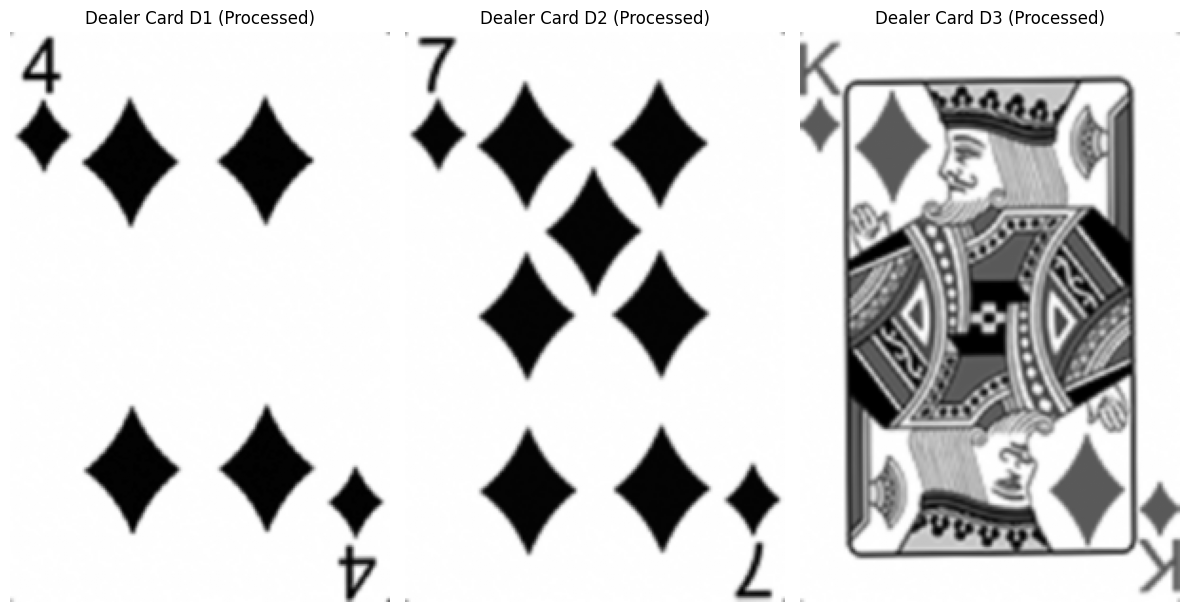

Processed 3 dealer cards for template matching.


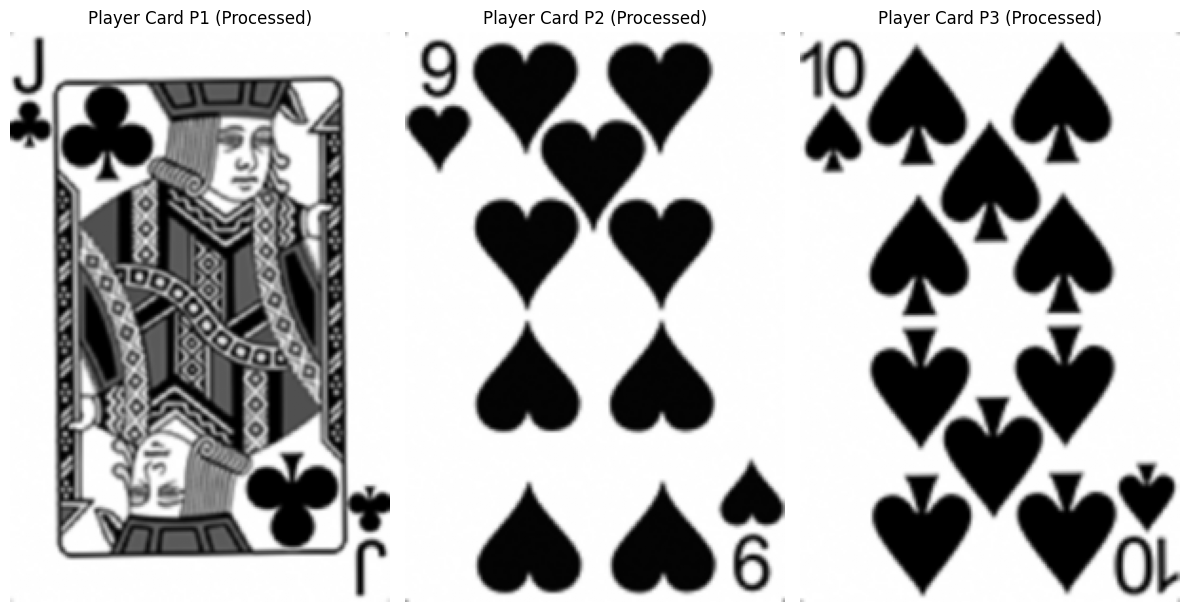

Processed 3 player cards for template matching.


In [36]:
processed_dealer_cards = []
for idx, card in enumerate(warped_dealer_cards):
    # Convert to grayscale for template matching
    card_gray = cv2.cvtColor(card, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    card_blurred = cv2.GaussianBlur(card_gray, (3, 3), 0)
    
    processed_dealer_cards.append(card_blurred)

processed_player_cards = []
for idx, card in enumerate(warped_player_cards):
    card_gray = cv2.cvtColor(card, cv2.COLOR_BGR2GRAY)
    card_blurred = cv2.GaussianBlur(card_gray, (3, 3), 0)
    processed_player_cards.append(card_blurred)

# Visualize the processed cards for dealer
if len(processed_dealer_cards) > 0:
    fig, axes = plt.subplots(1, len(processed_dealer_cards), figsize=(4 * len(processed_dealer_cards), 6))
    if len(processed_dealer_cards) == 1:
        axes = [axes]
    for i, card in enumerate(processed_dealer_cards):
        axes[i].imshow(card, cmap='gray')
        axes[i].set_title(f'Dealer Card D{i+1} (Processed)')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    print(f"Processed {len(processed_dealer_cards)} dealer cards for template matching.")

    # Visualize the processed cards for player
if len(processed_player_cards) > 0:
    fig, axes = plt.subplots(1, len(processed_player_cards), figsize=(4 * len(processed_player_cards), 6))
    if len(processed_player_cards) == 1:
        axes = [axes]
    for i, card in enumerate(processed_player_cards):
        axes[i].imshow(card, cmap='gray')
        axes[i].set_title(f'Player Card P{i+1} (Processed)')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    print(f"Processed {len(processed_player_cards)} player cards for template matching.")

🟩 Subtask 7: Load Card Templates from PNG-cards Folder
Goal: Load all card template images for whole-card comparison.

Explanation:

Load card images from PNG-cards/ folder with names like "rank_of_suit.png".

Handle special cases (ace_of_spades2, jack/queen/king variants with "2" suffix).

Resize templates to match warped card size and preprocess them.

Loaded card templates for 13 ranks:
  2: 4 template variations
  3: 4 template variations
  4: 4 template variations
  5: 4 template variations
  6: 4 template variations
  7: 4 template variations
  8: 4 template variations
  9: 4 template variations
  10: 4 template variations
  A: 5 template variations
  J: 8 template variations
  Q: 8 template variations
  K: 8 template variations


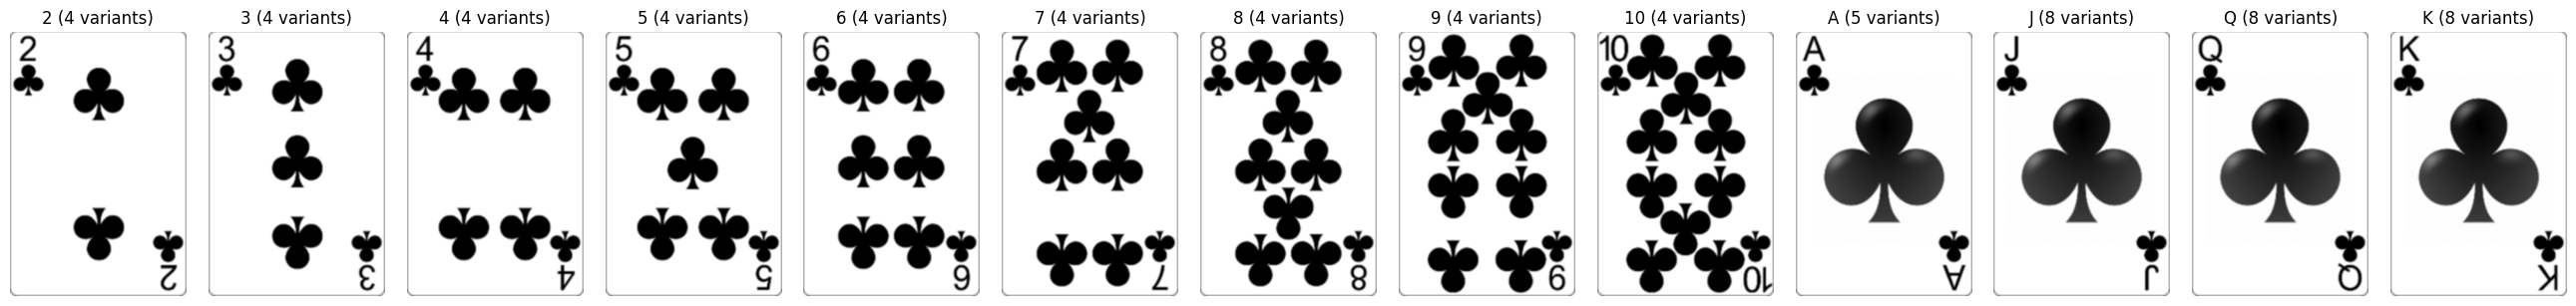


Total templates loaded: 65


In [37]:
# Subtask 7: Load Card Templates from PNG-cards Folder (unchanged)
# -----------------------------------------------------------------------------------

card_templates = {}
template_dir = 'PNG-cards/'

# Define all possible card combinations
ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'ace', 'jack', 'queen', 'king']
suits = ['clubs', 'diamonds', 'hearts', 'spades']

# Load all card templates
for rank in ranks:
    for suit in suits:
        # Standard naming convention
        template_name = f'{rank}_of_{suit}.png'
        template_path = os.path.join(template_dir, template_name)
        
        if os.path.exists(template_path):
            template_img = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
            # Resize to match warped card size (200x300)
            template_img = cv2.resize(template_img, (200, 300))
            # Apply same preprocessing as cards
            template_blurred = cv2.GaussianBlur(template_img, (3, 3), 0)
            
            # Store with simplified key for blackjack (rank only)
            if rank == 'ace':
                key = 'A'
            elif rank == 'jack':
                key = 'J'
            elif rank == 'queen':
                key = 'Q'
            elif rank == 'king':
                key = 'K'
            else:
                key = rank
            
            # Store multiple templates for each rank (different suits and variants)
            if key not in card_templates:
                card_templates[key] = []
            card_templates[key].append(template_blurred)
        
        # Check for variant templates (jack2, queen2, king2, ace_of_spades2)
        if rank in ['jack', 'queen', 'king'] or (rank == 'ace' and suit == 'spades'):
            variant_name = f'{rank}_of_{suit}2.png' if rank != 'ace' else 'ace_of_spades2.png'
            variant_path = os.path.join(template_dir, variant_name)
            
            if os.path.exists(variant_path):
                variant_img = cv2.imread(variant_path, cv2.IMREAD_GRAYSCALE)
                variant_img = cv2.resize(variant_img, (200, 300))
                variant_blurred = cv2.GaussianBlur(variant_img, (3, 3), 0)
                
                # Add to the same rank category
                if rank == 'ace':
                    key = 'A'
                elif rank == 'jack':
                    key = 'J'
                elif rank == 'queen':
                    key = 'Q'
                elif rank == 'king':
                    key = 'K'
                
                if key not in card_templates:
                    card_templates[key] = []
                card_templates[key].append(variant_blurred)

# Display summary of loaded templates
print(f"Loaded card templates for {len(card_templates)} ranks:")
for rank, templates in card_templates.items():
    print(f"  {rank}: {len(templates)} template variations")

# Visualize one template per rank
fig, axes = plt.subplots(1, len(card_templates), figsize=(2 * len(card_templates), 3))
if len(card_templates) == 1:
    axes = [axes]

for i, (rank, templates) in enumerate(card_templates.items()):
    axes[i].imshow(templates[0], cmap='gray')  # Show first template for each rank
    axes[i].set_title(f'{rank} ({len(templates)} variants)')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

print(f"\nTotal templates loaded: {sum(len(templates) for templates in card_templates.values())}")

🟩 Subtask 8: Whole Card Template Matching
Goal: Match each detected card against all template cards.

Explanation:

Compare the entire warped card against all template variations.

Use multiple similarity metrics for robust matching.

Find the best matching rank across all template variations.

In [38]:
# Advanced Whole Card Template Matching
# -----------------------------------------------------------------------------------

def correlation_score(card_img, template_img):
    """
    Computes normalized cross-correlation score between card and template.
    Returns a non-negative value.
    """
    result = cv2.matchTemplate(card_img, template_img, cv2.TM_CCOEFF_NORMED)
    return max(0, result[0, 0])  # Ensure non-negative


def structural_similarity_score(card_img, template_img):
    """
    Computes a simplified structural similarity based on image gradients.
    Returns a value between 0 and 1.
    """
    card_grad_x = cv2.Sobel(card_img, cv2.CV_64F, 1, 0, ksize=3)
    card_grad_y = cv2.Sobel(card_img, cv2.CV_64F, 0, 1, ksize=3)
    template_grad_x = cv2.Sobel(template_img, cv2.CV_64F, 1, 0, ksize=3)
    template_grad_y = cv2.Sobel(template_img, cv2.CV_64F, 0, 1, ksize=3)
    
    card_grad = np.sqrt(card_grad_x**2 + card_grad_y**2)
    template_grad = np.sqrt(template_grad_x**2 + template_grad_y**2)
    
    # Normalize gradients to [0, 1]
    card_grad = card_grad / (np.max(card_grad) + 1e-8)
    template_grad = template_grad / (np.max(template_grad) + 1e-8)
    
    # Calculate similarity as 1 - mean absolute difference
    diff = np.abs(card_grad - template_grad)
    similarity = 1 - np.mean(diff)
    return max(0, similarity)


def histogram_score(card_img, template_img):
    """
    Computes histogram correlation score between card and template.
    Returns a value between 0 and 1.
    """
    # Calculate histograms
    hist1 = cv2.calcHist([card_img], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([template_img], [0], None, [256], [0, 256])
    
    # Normalize histograms
    hist1 = hist1 / (np.sum(hist1) + 1e-8)
    hist2 = hist2 / (np.sum(hist2) + 1e-8)
    
    # Calculate correlation
    correlation = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    return max(0, correlation)


def combined_card_score(card_img, template_img):
    """
    Combines correlation, structural similarity, and histogram scores 
    into a single weighted score.
    Returns (combined_score, details_dict).
    """
    corr_score = correlation_score(card_img, template_img)
    struct_score = structural_similarity_score(card_img, template_img)
    hist_score = histogram_score(card_img, template_img)
    
    # Weighted combination: 50% correlation, 30% structural, 20% histogram
    weights = [0.5, 0.3, 0.2]
    combined = weights[0] * corr_score + weights[1] * struct_score + weights[2] * hist_score
    
    return combined, {'corr': corr_score, 'struct': struct_score, 'hist': hist_score}

In [39]:
# Perform whole-card template matching for dealer and player separately
# -----------------------------------------------------------------------------------

match_results_dealer = []
for idx, card_img in enumerate(processed_dealer_cards):
    best_rank = None
    best_score = -1
    best_details = None
    rank_scores = {}
    
    # Compare this card against all templates for each rank
    for rank, templates in card_templates.items():
        max_score_for_rank = -1
        best_details_for_rank = None
        
        for template in templates:
            combined_score, details = combined_card_score(card_img, template)
            if combined_score > max_score_for_rank:
                max_score_for_rank = combined_score
                best_details_for_rank = details
        
        rank_scores[rank] = max_score_for_rank
        if max_score_for_rank > best_score:
            best_score = max_score_for_rank
            best_rank = rank
            best_details = best_details_for_rank
    
    # Sort all ranks by score to get top-3 suggestions
    sorted_scores = sorted(rank_scores.items(), key=lambda x: x[1], reverse=True)
    top3 = sorted_scores[:3]
    
    match_results_dealer.append({
        'best_rank': best_rank,
        'best_score': best_score,
        'top3': top3,
        'details': best_details
    })

print("Whole card template matching complete for dealer's cards.")

match_results_player = []
for idx, card_img in enumerate(processed_player_cards):
    best_rank = None
    best_score = -1
    best_details = None
    rank_scores = {}
    
    for rank, templates in card_templates.items():
        max_score_for_rank = -1
        best_details_for_rank = None
        
        for template in templates:
            combined_score, details = combined_card_score(card_img, template)
            if combined_score > max_score_for_rank:
                max_score_for_rank = combined_score
                best_details_for_rank = details
        
        rank_scores[rank] = max_score_for_rank
        if max_score_for_rank > best_score:
            best_score = max_score_for_rank
            best_rank = rank
            best_details = best_details_for_rank
    
    sorted_scores = sorted(rank_scores.items(), key=lambda x: x[1], reverse=True)
    top3 = sorted_scores[:3]
    
    match_results_player.append({
        'best_rank': best_rank,
        'best_score': best_score,
        'top3': top3,
        'details': best_details
    })

print("Whole card template matching complete for player's cards.")


Whole card template matching complete for dealer's cards.
Whole card template matching complete for player's cards.


🟩 Subtask 9: Store & Print Match Results
Goal: Track what each card was classified as.

Explanation:

For each card, save its predicted rank and match confidence.

Optionally, print or visualize top matches for debugging.

In [40]:
# Dealer results
print("\n🎯 Enhanced Match Results for Dealer's Cards:\n")
print("=" * 60)
for idx, result in enumerate(match_results_dealer):
    print(f"\n📊 Dealer Card D{idx+1}:")
    print(f"   🏆 Predicted Rank: {result['best_rank']} (Overall: {result['best_score']*100:.1f}%)")
    details = result['details']
    print(f"   📈 Score Breakdown:")
    print(f"      • Correlation: {details['corr']*100:.1f}%")
    print(f"      • Structural: {details['struct']*100:.1f}%")
    print(f"      • Histogram: {details['hist']*100:.1f}%")
    print(f"   🥇 Top 3 Matches:")
    for i, (rank, score) in enumerate(result['top3']):
        medal = ["🥇", "🥈", "🥉"][i]
        print(f"      {medal} {rank}: {score*100:.1f}%")
    print("-" * 40)

# Player results
print("\n🎯 Enhanced Match Results for Player's Cards:\n")
print("=" * 60)
for idx, result in enumerate(match_results_player):
    print(f"\n📊 Player Card P{idx+1}:")
    print(f"   🏆 Predicted Rank: {result['best_rank']} (Overall: {result['best_score']*100:.1f}%)")
    details = result['details']
    print(f"   📈 Score Breakdown:")
    print(f"      • Correlation: {details['corr']*100:.1f}%")
    print(f"      • Structural: {details['struct']*100:.1f}%")
    print(f"      • Histogram: {details['hist']*100:.1f}%")
    print(f"   🥇 Top 3 Matches:")
    for i, (rank, score) in enumerate(result['top3']):
        medal = ["🥇", "🥈", "🥉"][i]
        print(f"      {medal} {rank}: {score*100:.1f}%")
    print("-" * 40)

print("\n✅ Multi-metric matching complete for both dealer and player!")


🎯 Enhanced Match Results for Dealer's Cards:


📊 Dealer Card D1:
   🏆 Predicted Rank: 4 (Overall: 85.0%)
   📈 Score Breakdown:
      • Correlation: 90.7%
      • Structural: 94.4%
      • Histogram: 56.4%
   🥇 Top 3 Matches:
      🥇 4: 85.0%
      🥈 5: 79.6%
      🥉 6: 69.5%
----------------------------------------

📊 Dealer Card D2:
   🏆 Predicted Rank: 7 (Overall: 84.9%)
   📈 Score Breakdown:
      • Correlation: 92.8%
      • Structural: 93.2%
      • Histogram: 52.9%
   🥇 Top 3 Matches:
      🥇 7: 84.9%
      🥈 8: 81.0%
      🥉 6: 75.9%
----------------------------------------

📊 Dealer Card D3:
   🏆 Predicted Rank: K (Overall: 77.6%)
   📈 Score Breakdown:
      • Correlation: 82.6%
      • Structural: 85.3%
      • Histogram: 53.1%
   🥇 Top 3 Matches:
      🥇 K: 77.6%
      🥈 J: 64.1%
      🥉 Q: 59.5%
----------------------------------------

🎯 Enhanced Match Results for Player's Cards:


📊 Player Card P1:
   🏆 Predicted Rank: J (Overall: 78.6%)
   📈 Score Breakdown:
      • Corr

In [41]:
# Subtask 10: Compute the final blackjack score for Dealer and Player
# -----------------------------------------------------------------------------------

print("\n🎲 Blackjack Score Calculation:\n" + "="*50)

# Define blackjack point values for each rank
blackjack_values = {
    'A': 11,    # Ace (we will adjust if necessary)
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    '10': 10,
    'J': 10,    # Jack
    'Q': 10,    # Queen  
    'K': 10     # King
}

def compute_blackjack_score(match_results, label_prefix):
    """
    Given template matching results for a group (dealer or player),
    compute the blackjack score, optimize Aces if needed, and print details.
    label_prefix: 'D' for dealer or 'P' for player (for printing).
    """
    total_score = 0
    detected_ranks = []
    
    print(f"\n📋 {label_prefix} Cards and their values:")
    for i, result in enumerate(match_results, 1):
        best_rank = result['best_rank']
        confidence = result['best_score'] * 100  # percentage
        card_value = blackjack_values[best_rank]
        total_score += card_value
        detected_ranks.append(best_rank)
        
        print(f"   {label_prefix}{i}: {best_rank} → {card_value} points (confidence: {confidence:.1f}%)")
    
    print(f"\n🎯 {label_prefix} Detected ranks: {', '.join(detected_ranks)}")
    print(f"🏆 {label_prefix} Total Blackjack Score (before Ace optimization): {total_score} points")
    
    # Handle Ace optimization if score > 21
    aces_count = detected_ranks.count('A')
    optimized_score = total_score
    if total_score > 21 and aces_count > 0:
        aces_to_convert = min(aces_count, (total_score - 21 + 10) // 10)
        optimized_score = total_score - (aces_to_convert * 10)
        if aces_to_convert > 0:
            print(f"\n🔄 {label_prefix} Ace optimization applied:")
            print(f"   Converted {aces_to_convert} Ace(s) from 11 to 1")
            print(f"   🎯 {label_prefix} Optimized Score: {optimized_score} points")
    
    # Final status
    if optimized_score == 21:
        print(f"🎉 {label_prefix} BLACKJACK! Perfect score of 21!")
    elif optimized_score > 21:
        print(f"💥 {label_prefix} BUST! Score of {optimized_score} exceeds 21")
    else:
        print(f"✅ {label_prefix} Valid hand with {optimized_score} points")
    print("=" * 50 + "\n")
    
    return optimized_score

# Compute for dealer and player
dealer_final = compute_blackjack_score(match_results_dealer, 'Dealer')
player_final = compute_blackjack_score(match_results_player, 'Player')


🎲 Blackjack Score Calculation:

📋 Dealer Cards and their values:
   Dealer1: 4 → 4 points (confidence: 85.0%)
   Dealer2: 7 → 7 points (confidence: 84.9%)
   Dealer3: K → 10 points (confidence: 77.6%)

🎯 Dealer Detected ranks: 4, 7, K
🏆 Dealer Total Blackjack Score (before Ace optimization): 21 points
🎉 Dealer BLACKJACK! Perfect score of 21!


📋 Player Cards and their values:
   Player1: J → 10 points (confidence: 78.6%)
   Player2: 9 → 9 points (confidence: 83.0%)
   Player3: 10 → 10 points (confidence: 85.6%)

🎯 Player Detected ranks: J, 9, 10
🏆 Player Total Blackjack Score (before Ace optimization): 29 points
💥 Player BUST! Score of 29 exceeds 21



🟩 Subtask 11 (Optional): Show Visual Debug Info
Goal: Make it easier to debug whole card mismatches.

Explanation:

Plot:

warped card image,

best-matching template card,

score breakdown visualization.

This helps you understand if detection failed due to lighting, angle, or card condition.



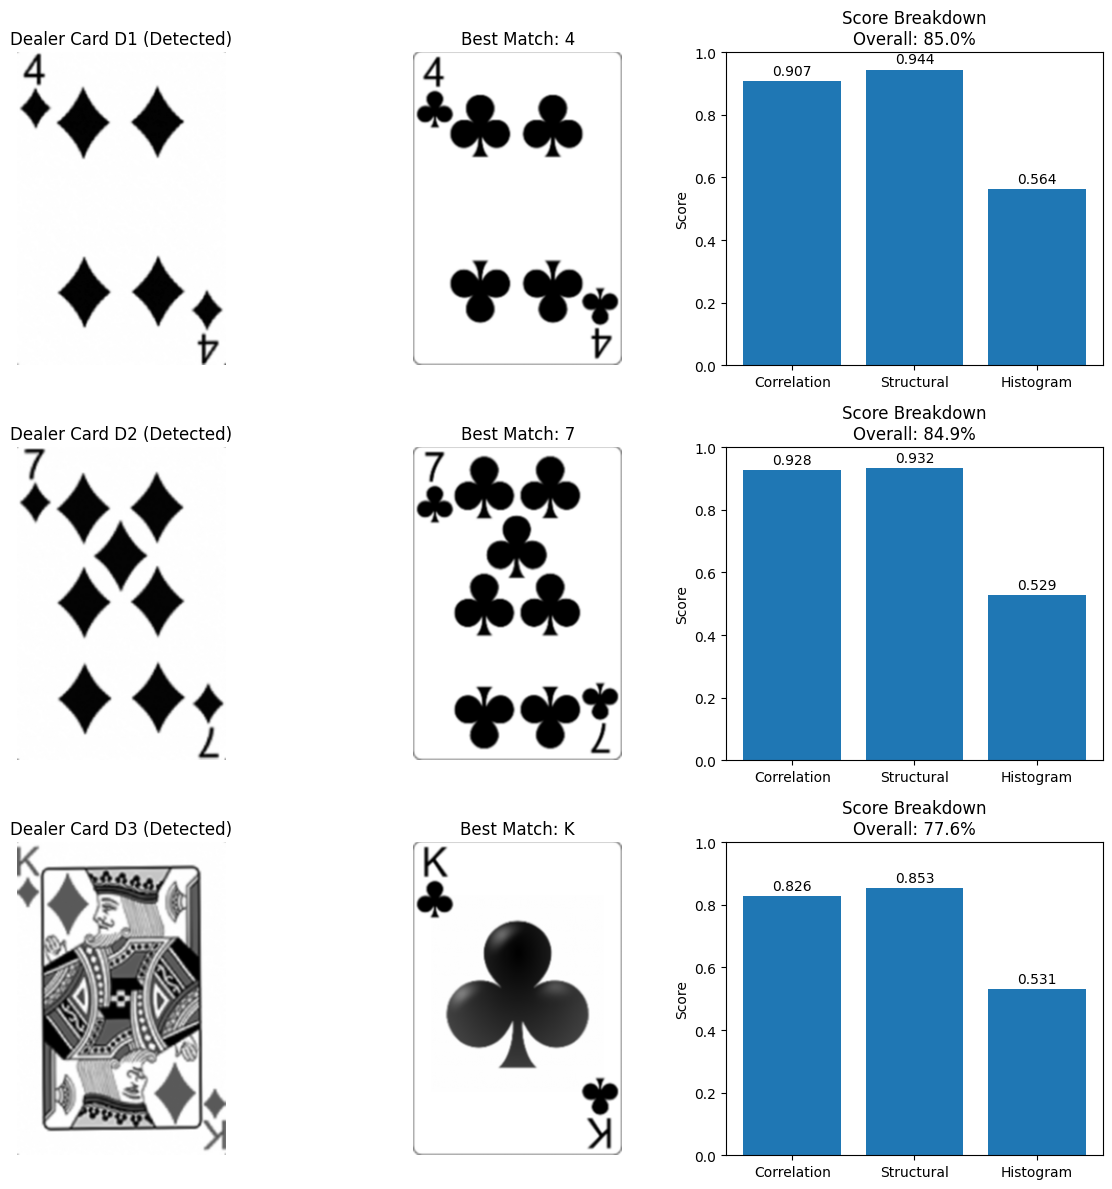


🔍 Dealer debug visualization complete for 3 cards.


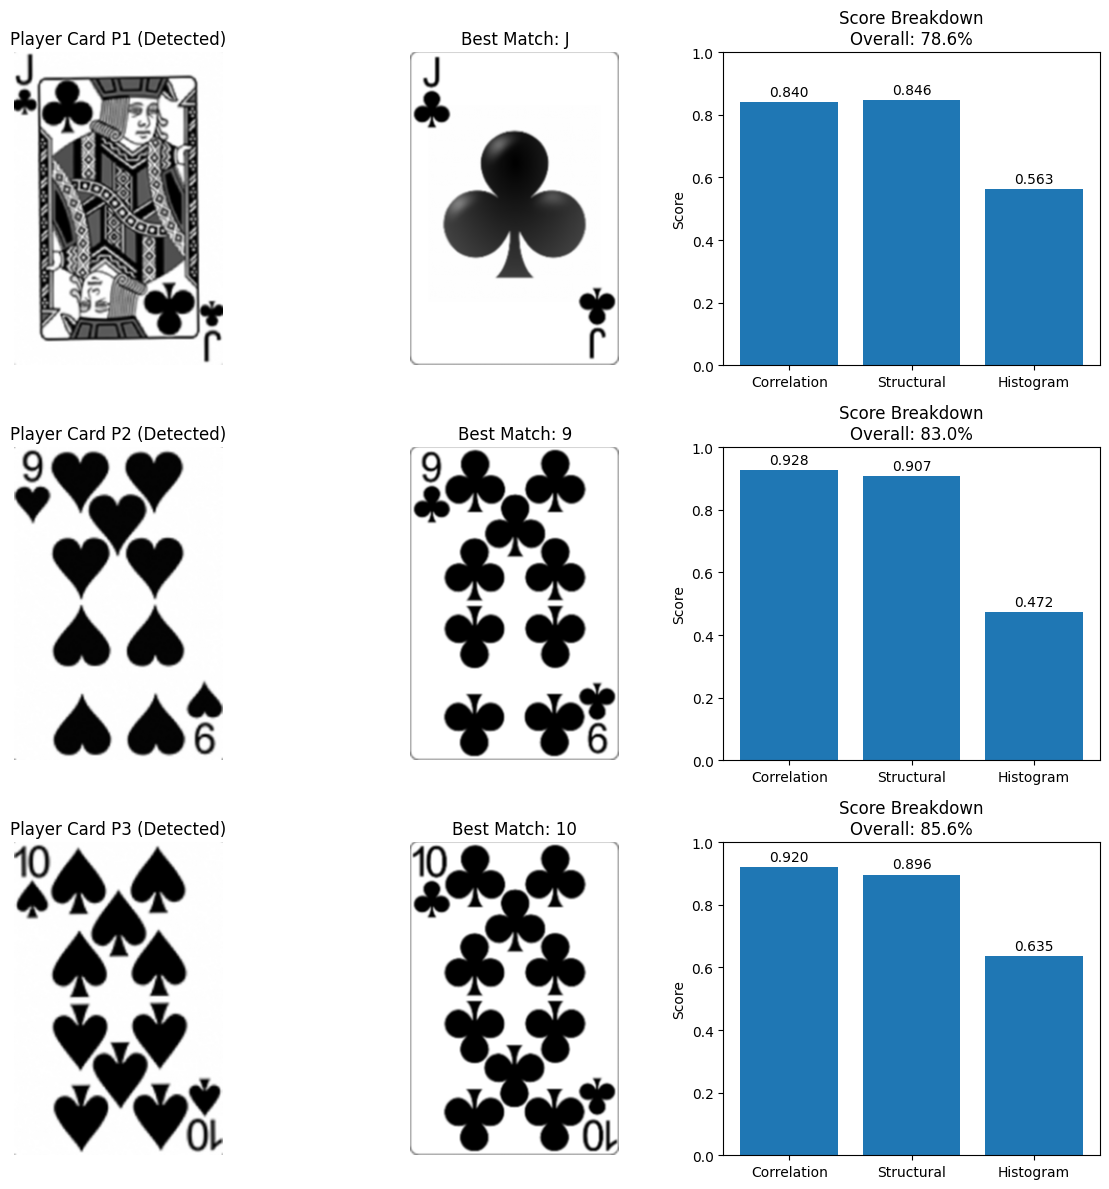


🔍 Player debug visualization complete for 3 cards.
All processing for dealer and player cards completed successfully!


In [42]:
# Subtask 11: Visual Debug Info for Whole Card Matching (both groups)
# -----------------------------------------------------------------------------------

# Dealer debug visualization
if len(match_results_dealer) > 0:
    fig, axes = plt.subplots(len(match_results_dealer), 3, figsize=(12, 4 * len(match_results_dealer)))
    if len(match_results_dealer) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, result in enumerate(match_results_dealer):
        # Show processed dealer card
        axes[idx, 0].imshow(processed_dealer_cards[idx], cmap='gray')
        axes[idx, 0].set_title(f'Dealer Card D{idx+1} (Detected)')
        axes[idx, 0].axis('off')
        
        # Show best matching template for dealer
        best_rank = result['best_rank']
        best_template = card_templates[best_rank][0]  # first variant
        axes[idx, 1].imshow(best_template, cmap='gray')
        axes[idx, 1].set_title(f'Best Match: {best_rank}')
        axes[idx, 1].axis('off')
        
        # Show score breakdown bar chart
        details = result['details']
        scores = [details['corr'], details['struct'], details['hist']]
        labels = ['Correlation', 'Structural', 'Histogram']
        bars = axes[idx, 2].bar(labels, scores)
        axes[idx, 2].set_title(f'Score Breakdown\nOverall: {result["best_score"]*100:.1f}%')
        axes[idx, 2].set_ylim(0, 1)
        axes[idx, 2].set_ylabel('Score')
        for bar, score in zip(bars, scores):
            height = bar.get_height()
            axes[idx, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                              f'{score:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    print(f"\n🔍 Dealer debug visualization complete for {len(match_results_dealer)} cards.")

# Player debug visualization
if len(match_results_player) > 0:
    fig, axes = plt.subplots(len(match_results_player), 3, figsize=(12, 4 * len(match_results_player)))
    if len(match_results_player) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, result in enumerate(match_results_player):
        # Show processed player card
        axes[idx, 0].imshow(processed_player_cards[idx], cmap='gray')
        axes[idx, 0].set_title(f'Player Card P{idx+1} (Detected)')
        axes[idx, 0].axis('off')
        
        # Show best matching template for player
        best_rank = result['best_rank']
        best_template = card_templates[best_rank][0]
        axes[idx, 1].imshow(best_template, cmap='gray')
        axes[idx, 1].set_title(f'Best Match: {best_rank}')
        axes[idx, 1].axis('off')
        
        # Show score breakdown bar chart
        details = result['details']
        scores = [details['corr'], details['struct'], details['hist']]
        labels = ['Correlation', 'Structural', 'Histogram']
        bars = axes[idx, 2].bar(labels, scores)
        axes[idx, 2].set_title(f'Score Breakdown\nOverall: {result["best_score"]*100:.1f}%')
        axes[idx, 2].set_ylim(0, 1)
        axes[idx, 2].set_ylabel('Score')
        for bar, score in zip(bars, scores):
            height = bar.get_height()
            axes[idx, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                              f'{score:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    print(f"\n🔍 Player debug visualization complete for {len(match_results_player)} cards.")

print("All processing for dealer and player cards completed successfully!")